In [ ]:
%reset -f
import sys
import numpy as np
sys.path.insert(0, '..')
from wavhandler import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
from utils_train import *
import deepdish as dd
import os
import glob
from natsort import natsorted
import matplotlib.pyplot as plt

# !cd /home/kalfasyan/projects/wingbeat_frequencies/temp_data/from_cluster/

In [2]:
os.chdir('/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/')
!pwd

/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results


### Helper functions

In [3]:
def extract_dl_results(d, custom=False):
    idx_bst = d['val_loss'].index(min(d['val_loss']))
    train_score = d['train_score'][idx_bst]
    val_score = d['val_score'][idx_bst]
#     train_loss = d['train_loss'][idx_bst]
#     val_loss = d['val_loss'][idx_bst]
    balanced_acc_test = d['balanced_acc_test']
    logloss_test = d['logloss_test']
    if custom:
        return train_score,val_score,balanced_acc_test,logloss_test
    else:
        return f'{train_score:.2f}-{val_score:.2f}-{balanced_acc_test:.2f}, {logloss_test:.2f}'

def extract_ml_results(d, custom=False):
    train_score = d['train_score']
    val_score = d['val_score']
    balanced_acc_test = d['balanced_acc_test']
    logloss_test = d['logloss_test']
    if custom:
        print(f'{train_score:.2f}-{val_score:.2f}-{balanced_acc_test:.2f}, {logloss_test:.2f}')
        return train_score,val_score,balanced_acc_test,logloss_test
    else:
        return f'{train_score:.2f}-{val_score:.2f}-{balanced_acc_test:.2f}, {logloss_test:.2f}'

fnames_dl = natsorted(glob.glob('/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/dl/**results.h5'))
#fnames_dl
fnames_ml = natsorted(glob.glob('/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/ml/**results.h5'))

# RESULTS TABLE

### DL results

In [4]:
for j, f in enumerate(fnames_dl):
    d = dd.io.load(f)['results']
    f = f.split('/')[-1][:-4]
    lk = list(d.keys())

    if len(lk) == 1:
        if lk[0] == 'random':
            print(f"{f}:\t\t {extract_dl_results(d['random'])}")
        elif lk[0] == 'randomcv':
            print(f"{f}:\t\t {extract_dl_results(d['randomcv'])}")
    elif len(lk) == 5:
        tmp = []
        for i in range(5):
            print(extract_dl_results(d[f'custom_{i}'], custom=True))
            tmp.append(extract_dl_results(d[f'custom_{i}'], custom=True))
        
        stacked = np.vstack(tmp)
        stacked = np.mean(stacked, axis=0)
        print(np.std([tmp[i][2] for i in range(len(tmp))]))
        print(f'{f}:\t\t {stacked[0]:.2f}-{stacked[1]:.2f}-{stacked[2]:.2f}, {stacked[3]:.2f}\n')


(0.9455241, 0.8789167, 0.6989166666666667, 1.1276157837592302)
(0.943457, 0.9241667, 0.6950833333333334, 1.139640567157215)
(0.9408366, 0.9275, 0.7019166666666666, 1.089044069471672)
(0.9368164, 0.93958336, 0.6979166666666666, 1.1172217509380278)
(0.94731444, 0.90508336, 0.6711666666666667, 1.4878051769333034)
0.011133033928109815
custom_raw_dl4tsc_inc_result:		 0.94-0.92-0.69, 1.19

random_raw_dl4tsc_inc_result:		 0.93-0.92-0.91, 0.23


In [5]:
print([tmp[i][2] for i in range(len(tmp))])

[0.6989166666666667, 0.6950833333333334, 0.7019166666666666, 0.6979166666666666, 0.6711666666666667]


## ML results

In [4]:
for j, f in enumerate(fnames_ml):
    print(f)
    d = dd.io.load(f)['results']
    f = f.split('/')[-1][:-4]
    lk = list(d.keys())

    if len(lk) == 1:
        if lk[0] == 'random':
            print(f"{f}:\t\t {extract_ml_results(d['random'])}")
        elif lk[0] == 'randomcv':
            print(f"{f}:\t\t {extract_ml_results(d['randomcv'])}")
    elif len(lk) > 5:
        
        tmp = []
#         for i in range(5):
            #print(extract_ml_results(d, custom=True))
        print(f"train_score: {d['train_score']}")
        print(f"val_score: {d['val_score']}")
        print(f"b_accs: {np.std(d['b_accs'])}")
        print(f"logloss: {d['logloss']}")
        print()
# #         stacked = np.vstack(tmp)
# #         stacked = np.mean(stacked, axis=0)
#         print(f'{f}:\t\t {stacked[0]:.2f}-{stacked[1]:.2f}-{stacked[2]:.2f}, {stacked[3]:.2f}\n')
        
#         break

/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/ml/random_psdHQ_randomforest_results.h5
random_psdHQ_randomforest_result:		 0.97-0.77-0.77, 0.69
/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/ml/random_psdHQ_xgboost_results.h5
random_psdHQ_xgboost_result:		 0.99-0.83-0.83, 0.48


# CONFUSION MATRIX

In [23]:
path_results = '/home/kalfasyan/projects/wingbeat_frequencies/temp_data/results/'
path_dl = f'{path_results}dl/'
path_ml = f'{path_results}ml/'

def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

def result_confusion_mat(data_setting=None, model_setting=None, splitting=None, cus=0, plot=True):
    if splitting == 'custom':
        d = dd.io.load(f'{path_dl}{splitting}_{data_setting}_{model_setting}_results.h5')['results'][f'custom_{cus}']
    elif splitting == 'random' or splitting == 'randomcv':
        d = dd.io.load(f'{path_dl}{splitting}_{data_setting}_{model_setting}_results.h5')['results'][splitting]

    y_pred = np.argmax(d['y_pred'], axis=1)
    y_test = d['y_test']
    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=0)

    integerMapping = get_integer_mapping(le)
    mapping = {v: k for k, v in integerMapping.items()}
    y = [mapping[x] for x in y_test]

    if plot:
        plt.figure(figsize=(20,14))
        labels = pd.Series(y).unique().tolist()
        cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
        sns.heatmap(cm, vmin=0, vmax=1, xticklabels=labels, yticklabels=labels, cmap=cmap,annot=True, annot_kws={"size": 18}, fmt='.2f')
    return cm

In [10]:
splitting = 'random'
data = Dataset('Wingbeats')
X_train, X_val, X_test, y_train, y_val, y_test, le = mosquito_data_split(splitting='custom', dataset=data, return_label_encoder=True)

Species: Ae. aegypti.
Read 85553 filenames in 1.41 seconds.
['20170212', '20170211', '20170209', '20170208', '20170210', '20170207', '20170213', '20161213', '20170206', '20161212']
82989 train filenames, 2564 test filenames
Species: Ae. albopictus.
Read 20231 filenames in 1.38 seconds.
['20170301', '20170228', '20170227', '20170103', '20170102']
17440 train filenames, 2791 test filenames
Species: An. arabiensis.
Read 19297 filenames in 1.39 seconds.
['20170131', '20170317', '20170318', '20170320', '20170205', '20170203', '20170204', '20170202', '20170319', '20170313', '20170201', '20170314', '20170316', '20170130', '20170206', '20170315']
12897 train filenames, 2831 test filenames
Species: An. gambiae.
Read 49471 filenames in 1.42 seconds.
['20170121', '20170120', '20170123', '20170118', '20170117', '20170119', '20170116', '20170122', '20170109', '20170110']
45471 train filenames, 4000 test filenames
Species: C. quinquefasciatus.
Read 74599 filenames in 1.38 seconds.
['20161220', '2016

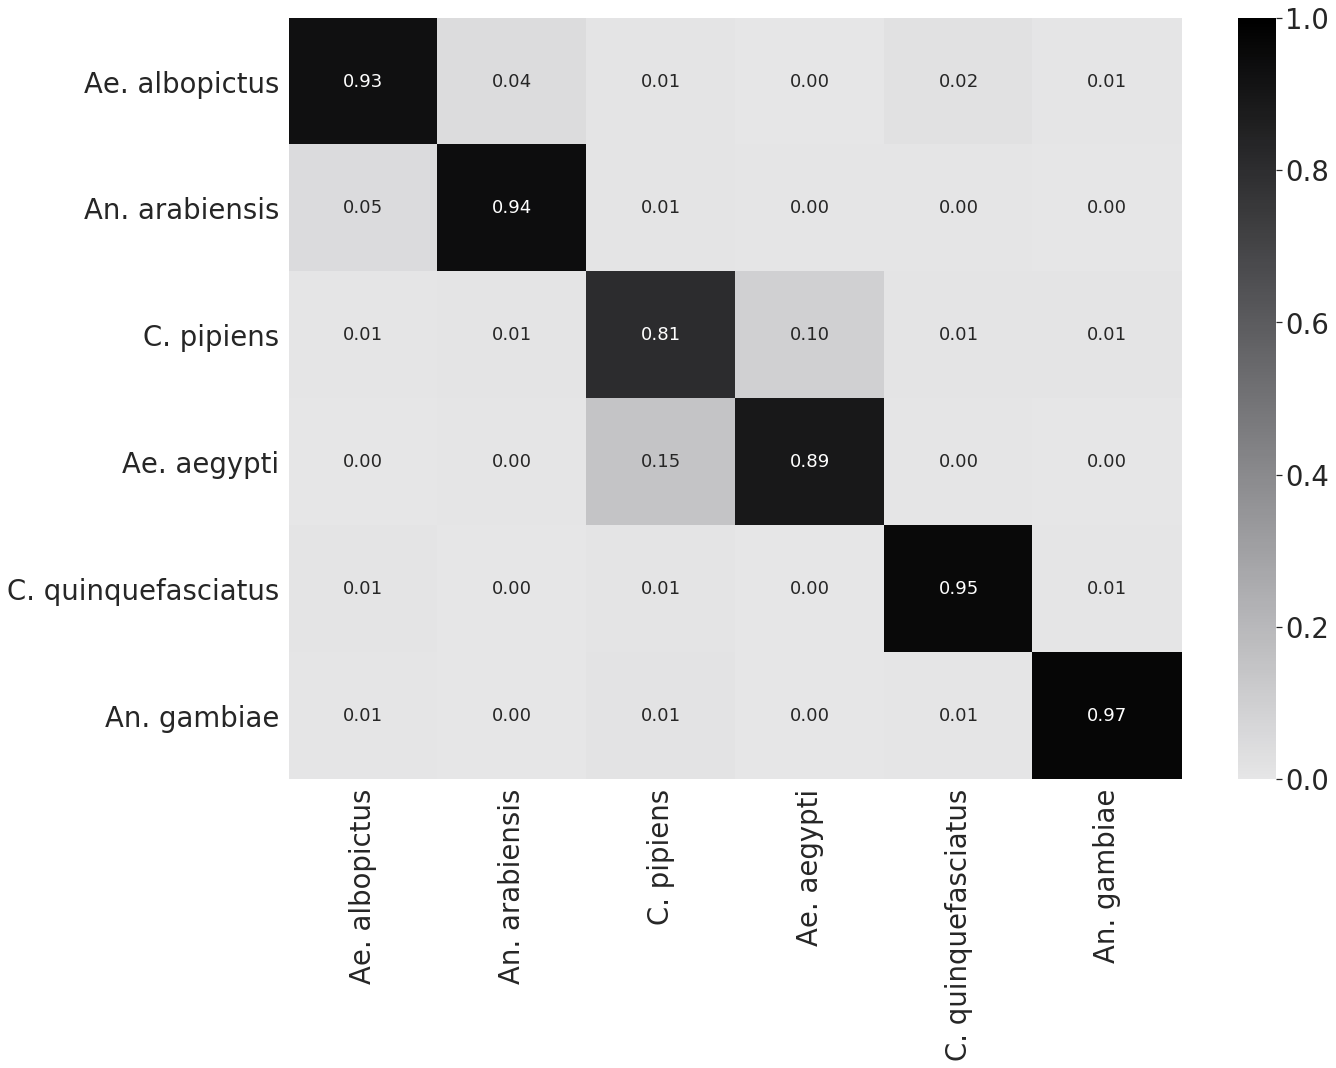

In [25]:
result_confusion_mat(data_setting = 'raw', model_setting = 'dl4tsc_inc', splitting='random');
plt.savefig(f'/home/kalfasyan/Desktop/cm_{splitting}.eps', format='eps')

In [15]:
# random 97,075

12000

In [28]:
(1757+1163+634+160 + 1553+197+348+1731  + 886+675+4+1955)/12000 * 100

92.19166666666668

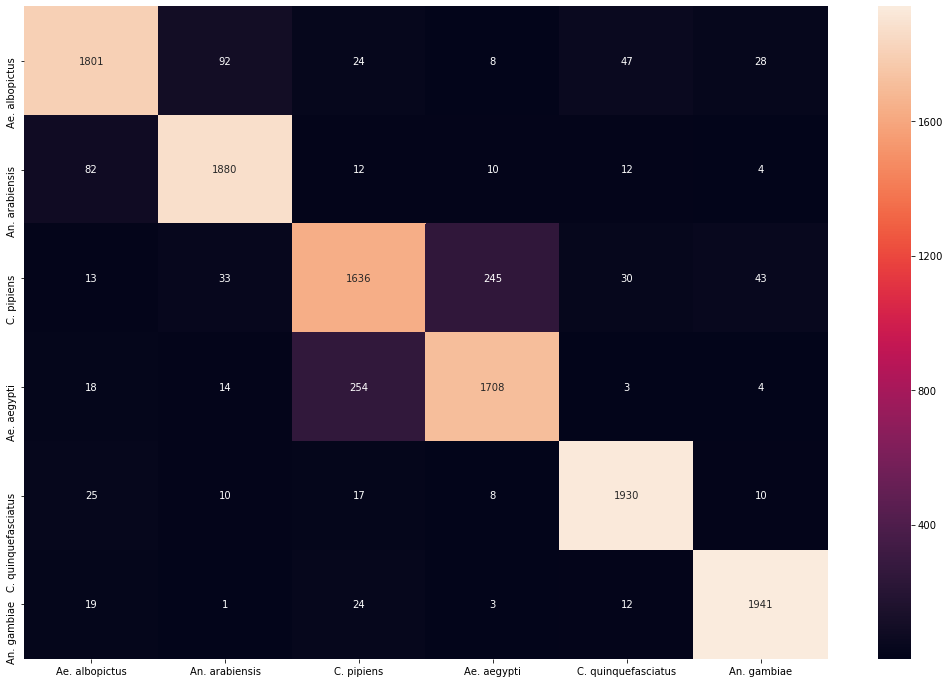

In [23]:
result_confusion_mat(data_setting = 'raw', model_setting = 'dl4tsc_inc', splitting='random');

## Average custom array

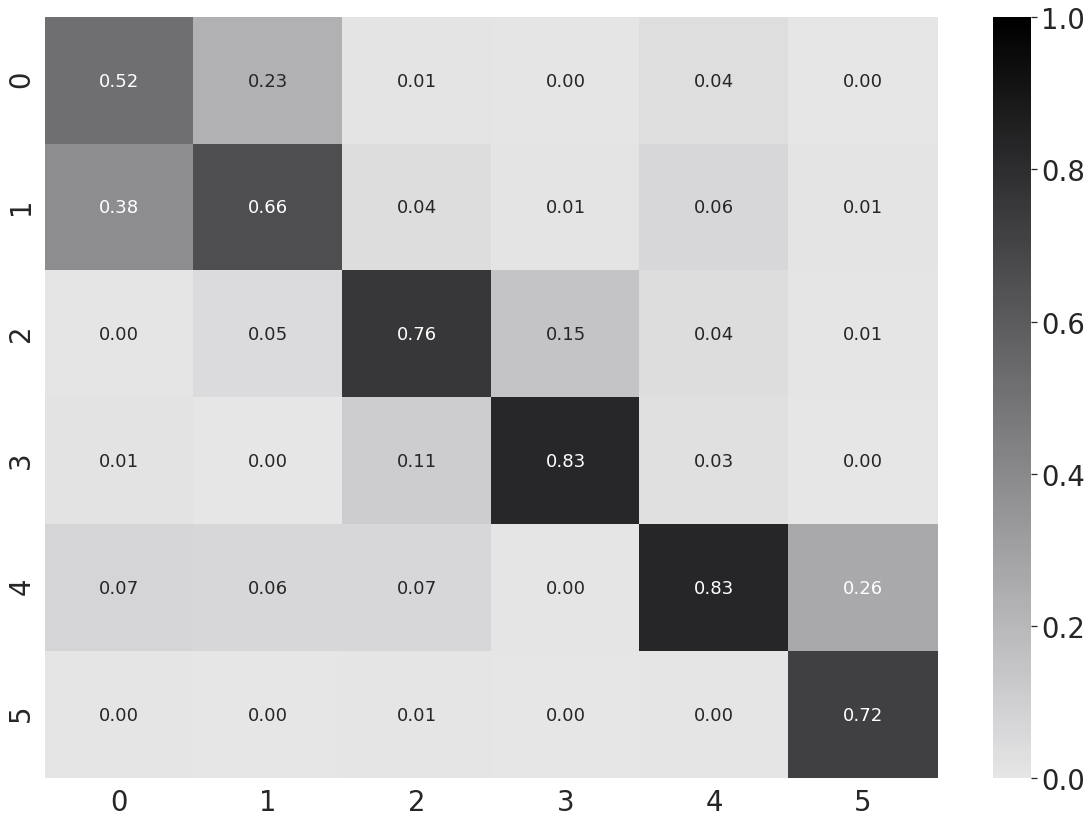

In [22]:
cms = []
for i in range(5):
    cms.append(result_confusion_mat(data_setting = 'raw', model_setting = 'dl4tsc_inc', splitting='custom', cus=i, plot=False))
cmfinal = np.average(cms, axis=0)
# sns.set(font_scale=2.5)
plt.figure(figsize=(20,14))
sns.heatmap(cmfinal, annot=True, vmin=0, vmax=1,cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True), annot_kws={"size": 18}, fmt='.2f')
plt.savefig(f'/home/kalfasyan/Desktop/cm_custom.eps', format='eps')